In [1]:
import matplotlib
if 'init_done' in globals():
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })
import matplotlib.pyplot as plt

import numpy as np
import pickle
import sklearn.metrics
import pandas as pd

init_done = True

In [2]:
RANDOM_STATE = 42
MAX_ROUNDS = 100
PATIENCE = 30
X_KEY = 'window_length'
X_LABEL = '$\Delta t_{pred}$ in [h]'

GROUPS = [
  { # Group 1:
    'name':             'CML ($\Delta t_{min} = 24~\mathrm{h}$)',
    'n_clients':        [1],
    'window_length':    [8,16,24],
    'labels':           [35.2, 27.2, 19.2],
    'min_los_icu':      24,
    'fl':               False,
    'folder_suffix':    ''
  },
  { # Group 2:
    'name':             'CML ($\Delta t_{min} = 48~\mathrm{h}$)',
    'n_clients':        [1],
    'window_length':    [32,40,48],
    'labels':           [35.3, 27.3, 19.3],
    'min_los_icu':      48,
    'fl':               False,
    'folder_suffix':    ''
  },
  { # Group 3:
    'name':             'FL ($\Delta t_{min} = 24~\mathrm{h}$)',
    'n_clients':        [8],
    'window_length':    [8,16,24],
    'labels':           [35.2, 27.2, 19.2],
    'min_los_icu':      24,
    'fl':               True,
    'folder_suffix':    ''
  },
  { # Group 4:
    'name':             'FL ($\Delta t_{min} = 48~\mathrm{h}$)',
    'n_clients':        [8],
    'window_length':    [32,40,48],
    'labels':           [35.3, 27.3, 19.3],
    'min_los_icu':      48,
    'fl':               True,
    'folder_suffix':    ''
  }
]

# Prepare Data

## Load Groups

In [3]:
def load(group, n, l):
    # Create data path:
    path =  f'../scores/min{group["min_los_icu"]:d}h/{l:d}h{group["folder_suffix"]:s}/'
    path += ('scores_fl_' if group['fl'] and n != 1 else 'scores_')
    path += f'{n:d}clients_{l:d}h(min{group["min_los_icu"]:d}h).pickle'

    print(f'Loading file "{path:s}"', end='...')

    # Add subdictionaries to data-tree if necessary:
    if not 'scores' in  group:
        group['scores'] = {'train':{}, 'valid':{}, 'test':{}}
        
    if not 'predictions' in group:
        group['predictions'] = {}

    # Select key:
    key = None
    if X_KEY == 'n_clients':
        key = n
        
    elif X_KEY == 'window_length':
        key = l

    # Load data:
    try:
        with open(path, 'rb') as file:
            group['scores']['train'][key], group['scores']['valid'][key], group['scores']['test'][key], group['predictions'][key] = pickle.load(file)
    except:
        with open(path, 'rb') as file:
            group['scores']['train'][key], group['scores']['valid'][key], group['scores']['test'][key] = pickle.load(file)

    print(f'Done.')

In [4]:
for group in GROUPS:
    # Sort lists:
    group['n_clients'].sort()
    group['window_length'].sort()

    # Load data:
    for n in group['n_clients']:
        for l in group['window_length']:
            load(group, n, l)

Loading file "../scores/min24h/8h/scores_1clients_8h(min24h).pickle"...Done.
Loading file "../scores/min24h/16h/scores_1clients_16h(min24h).pickle"...Done.
Loading file "../scores/min24h/24h/scores_1clients_24h(min24h).pickle"...Done.
Loading file "../scores/min48h/32h/scores_1clients_32h(min48h).pickle"...Done.
Loading file "../scores/min48h/40h/scores_1clients_40h(min48h).pickle"...Done.
Loading file "../scores/min48h/48h/scores_1clients_48h(min48h).pickle"...Done.
Loading file "../scores/min24h/8h/scores_fl_8clients_8h(min24h).pickle"...Done.
Loading file "../scores/min24h/16h/scores_fl_8clients_16h(min24h).pickle"...Done.
Loading file "../scores/min24h/24h/scores_fl_8clients_24h(min24h).pickle"...Done.
Loading file "../scores/min48h/32h/scores_fl_8clients_32h(min48h).pickle"...Done.
Loading file "../scores/min48h/40h/scores_fl_8clients_40h(min48h).pickle"...Done.
Loading file "../scores/min48h/48h/scores_fl_8clients_48h(min48h).pickle"...Done.


## Recalculate Scores with sk-learn

In [5]:
import assets
from helpers import enumerate_predictions
n_labels = 2
n_fold = 5

def recalculate_scores(group, key):
    # Init scores-arrays:
        group['scores']['test'][key]['AUROC'] = np.zeros((n_fold, n_labels))
        group['scores']['test'][key]['AUPRC'] = np.zeros((n_fold, n_labels))
        group['scores']['test'][key]['F1'] = np.zeros((n_fold, n_labels))
        group['scores']['test'][key]['precision'] = np.zeros((n_fold, n_labels))
        group['scores']['test'][key]['recall'] = np.zeros((n_fold, n_labels))
        
        # Calculate actual number of scores:
        n = None
        if group['fl']:
            n = 1

        elif X_KEY == 'n_clients':
            n = key

        else:
            n = group['n_clients'][-1]
        
        for fold in range(n_fold):
            f = 1. / float(n) 
            for i in range(n):
                y_true = []
                y_pred = []
                for t, p in enumerate_predictions(group['predictions'][key], n_labels=n_labels, client=i, fold=fold):
                    y_true.append(t.astype(int))
                    y_pred.append(p.astype(float))
                y_true = np.array(y_true)
                y_pred = np.array(y_pred)

                # Calculate classification metrics:
                for label in range(n_labels):
                    prc_crv, rcl_crv, _ = sklearn.metrics.precision_recall_curve(y_true[:, label], y_pred[:, label])
                    precision = sklearn.metrics.precision_score(y_true[:, label], np.round(y_pred[:, label]))
                    recall = sklearn.metrics.recall_score(y_true[:, label], np.round(y_pred[:, label]))

                    group['scores']['test'][key]['AUROC'][fold, label] += f * sklearn.metrics.roc_auc_score(y_true[:, label], y_pred[:, label])
                    group['scores']['test'][key]['AUPRC'][fold, label] += f * sklearn.metrics.auc(rcl_crv, prc_crv)
                    group['scores']['test'][key]['F1'][fold, label] += f * 2 * precision * recall / (precision + recall)
                    group['scores']['test'][key]['precision'][fold, label] += f * precision
                    group['scores']['test'][key]['recall'][fold, label] += f * recall

2024-05-16 14:22:38.634289: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 14:22:38.678090: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 14:22:38.975380: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 14:22:40.087900: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
for group in GROUPS:
    for key in group['predictions']:
        recalculate_scores(group, key)

/home/zainab/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_84480/2581517664.py:44: RuntimeWarning: invalid value encountered in scalar divide
  group['scores']['test'][key]['F1'][fold, label] += f * 2 * precision * recall / (precision + recall)
/home/zainab/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_84480/2581517664.py:44: RuntimeWarning: invalid value encountered in scalar divide
  group['scores']['test'][key]['F1'][fold, label] += f * 2 * prec

# Analyze data

In [7]:
colors = [
    '#f37500', #(234, 117,   0)
    '#069a2E', #(  6, 154,  46)
    '#3465a4', #( 52, 101, 164)
    '#780373', #(120,   3, 115)
    '#f10d0c'  #(241,  13,  12)
]

c = 0
for group in GROUPS:
    group['color'] = colors[c]
    c += 1

In [8]:
def comparative_plot(metric, ax, y_ticks=(0., .25, .5, .75, 1.), legend=True):
    for group in GROUPS:
        # Create x-values:
        x = group['labels' if 'labels' in group else X_KEY]

        # Calculate curves:
        y_avg = [np.nanmean(group['scores']['test'][n][metric][:,1:]) for n in group[X_KEY]]
        y_std = [np.nanstd(group['scores']['test'][n][metric][:,1:]) for n in group[X_KEY]]

        # Plot curves:
        ax.errorbar(x, y_avg, yerr=y_std, color=group['color'], label=group['name'], linestyle='--', fmt='o', linewidth=2, capsize=6)

    ax.set_yticks(y_ticks)
    ax.set_ylim((min(y_ticks), max(y_ticks)))

    ax.set_xlabel(X_LABEL)

    ax.set_title(metric)
    if legend: ax.legend()

## Create Legend:

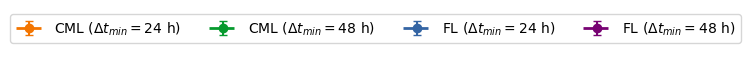

In [9]:
from matplotlib.container import ErrorbarContainer
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection

def create_errorbar_marker(color):
    l = Line2D([], [], linestyle='--', marker='o', linewidth=2, color=color)
    return ErrorbarContainer((l, [l], [LineCollection(np.empty((2,2,2)), colors=color)]), has_xerr=False, has_yerr=True)

fig = plt.figure(figsize=(8, .5))
ax = fig.add_subplot(1, 1, 1)

ax.legend(
    handles=[create_errorbar_marker(group['color']) for group in GROUPS],
    labels=[group['name'] for group in GROUPS],
    loc='center',
    ncol=len(GROUPS)
)
plt.axis('off')
plt.show()

#fig.savefig(f'./pictures/Legend_{"_".join([group["name"] for group in GROUPS]):s}.pdf')

## Compare AUROC

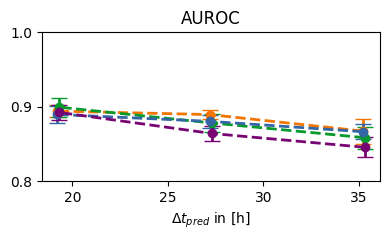

In [10]:
fig = plt.figure(figsize=(4, 2.5))

comparative_plot('AUROC', fig.add_subplot(1, 1, 1), y_ticks=(.8, .9, 1.), legend=False)

plt.locator_params(axis='x', nbins=4)
plt.tight_layout()
plt.show()

#fig.savefig(f'./pictures/AUROC_{"_".join([group["name"] for group in GROUPS]):s}.pdf')

## Plot AUPRC

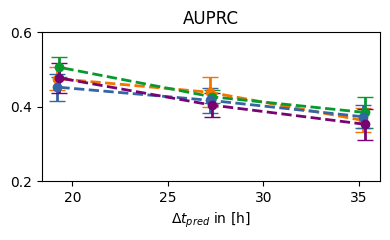

In [11]:
fig = plt.figure(figsize=(4, 2.5))

comparative_plot('AUPRC', fig.add_subplot(1, 1, 1), y_ticks=(.2, .4, .6), legend=False)

plt.locator_params(axis='x', nbins=4)
plt.tight_layout()
plt.show()

#fig.savefig(f'./pictures/AUPRC_{"_".join([group["name"] for group in GROUPS]):s}.pdf')

## Plot F1

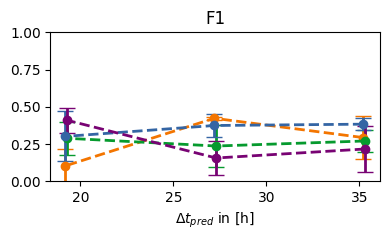

In [12]:
fig = plt.figure(figsize=(4, 2.5))

comparative_plot('F1', fig.add_subplot(1, 1, 1), legend=False)

plt.locator_params(axis='x', nbins=4)
plt.tight_layout()
plt.show()

#fig.savefig(f'./pictures/F1_{"_".join([group["name"] for group in GROUPS]):s}.pdf')

## Plot recall and precision:

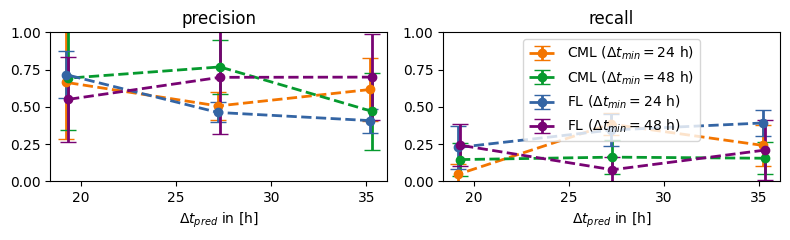

In [13]:

fig = plt.figure(figsize=(8, 2.5))

comparative_plot('precision', fig.add_subplot(1, 2, 1), legend=False)
plt.locator_params(axis='x', nbins=4)

comparative_plot('recall', fig.add_subplot(1, 2, 2))
plt.locator_params(axis='x', nbins=4)

plt.tight_layout()
plt.show()